In [1]:
# Tiina Manninen
# Ca_free is a constant
# Implementation of astrocyte model by Riera et al. (2011)
# Riera, J., Hatanaka, R., Ozaki, T., and Kawashima, R. (2011a). Modeling the spontaneous Ca2+ oscillations
# in astrocytes: Inconsistencies and usefulness. J. Integr. Neurosci. 10, 439–473.
# Riera, J., Hatanaka, R., Uchida, T., Ozaki, T., and Kawashima, R. (2011b). Quantifying the uncertainty
# of spontaneous Ca2+ oscillations in astrocytes: Particulars of Alzheimer’s disease. Biophys. J. 101, 554–564.

# Model implemented and ran using Jupyter Notebook.

# Model code used in publication: Manninen, T., Havela, R., and Linne, M.-L. (2017). 
# Reproducibility and comparability of computational models for astrocyte calcium excitability.
# Front. Neuroinform.

import numpy as np

class ModelSystem:
    def __init__(self, params, rate):
        self.params = params
        self.rate = rate
        
    def computeDeriv(self, state, t):
        Ca, h, IP3 = state
        modelPar = self.params
        X_IP3 = self.rate
        
        # Intermediate variables
        alpha_h = modelPar.a * modelPar.d_2 * (IP3 + modelPar.d_1) / (IP3 + modelPar.d_3)
        beta_h = modelPar.a * Ca
        Ca_ER = (modelPar.Ca_free - Ca) / modelPar.c_1
        m_infty = IP3 * Ca / ((IP3 + modelPar.d_1)*(Ca + modelPar.d_5))
        PLC_delta1 = modelPar.v_delta * Ca ** 2 / (Ca ** 2 + modelPar.K_deltaCa ** 2)
        v_CCE = modelPar.x_CCE * modelPar.H_CCE ** 2 / (modelPar.H_CCE ** 2 + Ca_ER ** 2)
        v_out = modelPar.k_out * Ca
        v_Rel = modelPar.c_1 * (modelPar.v_1 * m_infty ** 3 * h ** 3 + modelPar.v_2)\
                * (Ca_ER - Ca)     
        v_SERCA = modelPar.V_SERCA * Ca ** 2 / (Ca ** 2 + modelPar.K_p ** 2)
        
        # dx/dt 
        dCa_per_dt = v_Rel - v_SERCA + modelPar.epsilon * (modelPar.j_in + v_CCE - v_out)
        dh_per_dt = alpha_h * (1 - h) - beta_h * h # This equation corrected
        dIP3_per_dt = X_IP3(t) + PLC_delta1 - modelPar.K_IP3 * IP3
        
        deriv = [dCa_per_dt, dh_per_dt, dIP3_per_dt]
        return deriv  

In [2]:
class ModelParameters:
    a = 0.2            # 1/(uM s)
    c_1 = 0.185        # 1
    Ca_free = 2        # uM
    d_1 = 0.13         # uM
    d_2 = 1.049        # uM
    d_3 = 0.9434       # uM
    d_5 = 0.082        # uM
    epsilon = 0.01     # uM
    H_CCE = 10         # uM
    j_in = 0.065       # uM/s
    K_IP3 = 1.25       # 1/s
    K_deltaCa = 0.55   # uM 
    k_out = 0.5        # 1/s
    K_p = 0.1          # uM
    v_1 = 6            # 1/s
    v_2 = 0.11         # 1/s
    v_delta = 0.152    # uM/s
    V_SERCA = 0.9      # uM/s
    x_CCE = 0.01       # uM/s

In [3]:
def baseRate(t, minRate = 0, maxRate = 0.43, duration = 800, startTime = 100):
    if (t < startTime):
        return minRate
    if (t >= startTime + duration):
        return minRate
    if (startTime <= t < startTime + duration):
        return maxRate
    
    return minRate

In [4]:
params = ModelParameters()
modelRate_1 = baseRate                             # uM/s
modelRate_2 = lambda t: baseRate(t, minRate = 0.2) # uM/s
modelRate_3 = lambda t: 0                          # uM/s

mySys_1 = ModelSystem(params, modelRate_1)
mySys_2 = ModelSystem(params, modelRate_2)
mySys_3 = ModelSystem(params, modelRate_3)

In [5]:
from scipy.integrate import odeint
initial = [0.09, 0.79, 0.14] # uM, 1, uM

Tmax = 1200
dt = 0.1
t = np.arange(0,Tmax,dt)

data_1 = odeint(mySys_1.computeDeriv, initial, t, hmax=0.0005)
data_2 = odeint(mySys_2.computeDeriv, initial, t, hmax=0.0005)
data_3 = odeint(mySys_3.computeDeriv, initial, t, hmax=0.0005)

Populating the interactive namespace from numpy and matplotlib


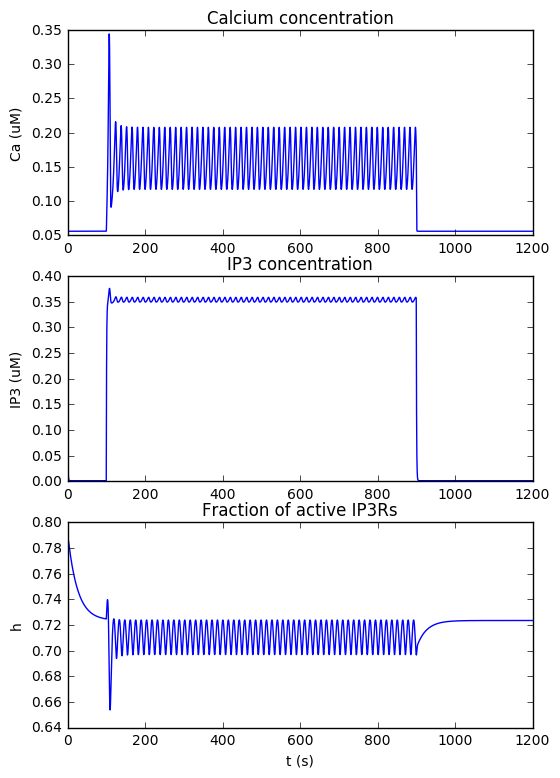

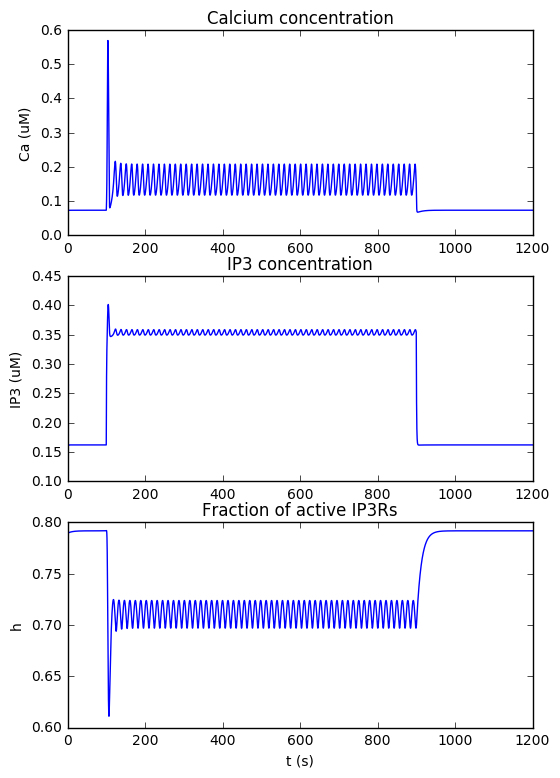

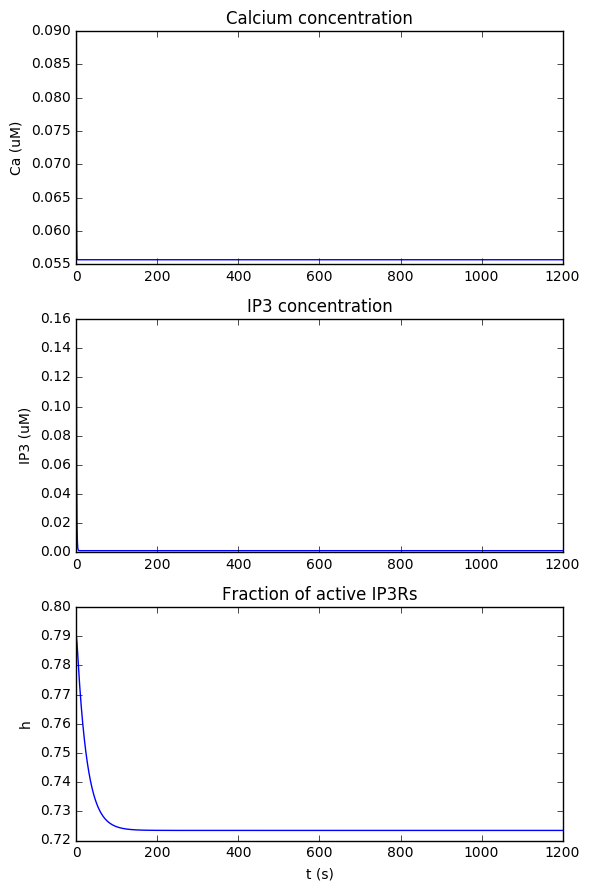

In [6]:
%pylab inline
import matplotlib.pyplot as plt

for pic in [(modelRate_1, data_1), (modelRate_2, data_2) , (modelRate_3, data_3)]:
    modelRate_f, data_f = pic
    plt.figure(figsize=(6, 9), dpi=200)

    plt.subplot(3,1,1)
    plt.plot(t, data_f[:,0])
    plt.title('Calcium concentration')
    plt.ylabel('Ca (uM)')

    plt.subplot(3,1,2)
    plt.plot(t, data_f[:,2])
    plt.title('IP3 concentration')
    plt.ylabel('IP3 (uM)')

    plt.subplot(3,1,3)
    plt.plot(t, data_f[:,1])
    plt.title('Fraction of active IP3Rs')
    plt.ylabel('h')
    plt.xlabel('t (s)')

plt.tight_layout()


np.savetxt('Riera2011_Cafree_constant_XIP3_0_in_beginning.csv', (t, list(map(modelRate_1, t)), data_1[:,0], data_1[:,1], data_1[:,2]), delimiter=',')
np.savetxt('Riera2011_Cafree_constant_XIP3_0_2_in_beginning.csv', (t, list(map(modelRate_2, t)), data_2[:,0], data_2[:,1], data_2[:,2]), delimiter=',')
np.savetxt('Riera2011_Cafree_constant_XIP3_0.csv', (t, list(map(modelRate_3, t)), data_3[:,0], data_3[:,1], data_3[:,2]), delimiter=',')